In [1]:
import pandas as pd
import numpy as np
import flip_data
import gd_poisoner
import datetime

# Import Training, Testing and Validating Set

In [2]:
poi_train_x = pd.read_csv('train_X.csv')
print("ori train ", poi_train_x.shape[0])
poi_train_x = np.matrix(poi_train_x.to_numpy())
print("matrix train ", len(poi_train_x))
poi_train_y = pd.read_csv('train_y.csv')
print("ori train y ", poi_train_y.shape[0])
poi_train_y = poi_train_y['Life Expectancy'].tolist()
print("matrix train y ", len(poi_train_y))
poi_test_x = pd.read_csv('test_X.csv')
poi_test_x = np.matrix(poi_test_x.to_numpy())
poi_test_y = pd.read_csv('test_y.csv')
poi_test_y = poi_test_y['Life Expectancy'].tolist()
poi_val_x = pd.read_csv('val_X.csv')
poi_val_x = np.matrix(poi_val_x.to_numpy())
poi_val_y = pd.read_csv('val_y.csv')
poi_val_y = poi_val_y['Life Expectancy'].tolist()

print (poi_train_x[0])
print (poi_train_y[0])

ori train  1319
matrix train  1319
ori train y  1319
matrix train y  1319
[[2.00900000e+03 0.00000000e+00 2.52077562e-01 2.22222222e-03
  1.14221725e-01 6.87422107e-04 9.79591837e-01 9.89711711e-05
  2.10892236e-01 1.60000000e-03 9.79166667e-01 1.74114916e-01
  9.79381443e-01 0.00000000e+00 1.80413125e-03 1.54066216e-05
  5.50724638e-01 5.36842105e-01 7.75316456e-01 6.47342995e-01]]
0.6736242884250474


# Define Main Arguments

In [3]:
# num of poisoning points
poison_ct = 300
# num of points to train model
train_ct = len(poi_train_x)
test_ct = len(poi_test_x)
# proportion of poisoning
total_prop = poison_ct / (poison_ct + train_ct)
print ("Posion count: ", poison_ct, " Train count: ", train_ct, " Test count: ", test_ct, " Proportion of poisoning: ", total_prop)

Posion count:  300  Train count:  1319  Test count:  165  Proportion of poisoning:  0.1852995676343422


# Perform Inverse Flip

In [4]:
x_pois, y_pois = flip_data.flip_data.inverse_flip(poi_train_x,poi_train_y,poison_ct)

y_opp [0. 0. 0. ... 0. 0. 0.]
stats [0. 0. 0. ... 0. 0. 0.]
total_prob 132.78026565464893
x_pois len:  300
x_pois col ct: 20
y_pois len:  300


# Show Attack Result after 'flipping' and 'flipping & poisoning' on the Model

classifier:  LinearRegression()
*****************************
**** Poison Count:  51  ****
*****************************
Iteration  0 
Objective Value:  0.006463523029787835  Change:  0.006463523029787835
Validation MSE  0.004954737872656076 
Test MSE  0.007086034388305386
 
Iteration  1
Objective Value: 0.004738426904237614  Difference:  -0.001725096125550221
NO PROGRESS MADE!
 
Iteration  2
Objective Value: 0.004742408469717502  Difference:  -0.0017211145600703331
NO PROGRESS MADE!
 
Iteration  3
Objective Value: 0.004744636082292185  Difference:  -0.0017188869474956498
NO PROGRESS MADE!
 
(51, 20) (1319, 20)
x_pois_result len:  51 , y_pois_result len:  51 , x_poised len:  1370 , y_poised len:  1370
classifier_poised  LinearRegression() , classifier2  LinearRegression()
 
*****************************
**** Poison Count:  106  ****
*****************************
Iteration  0 
Objective Value:  0.009675117905158754  Change:  0.009675117905158754
Validation MSE  0.007970895323907115 
Tes

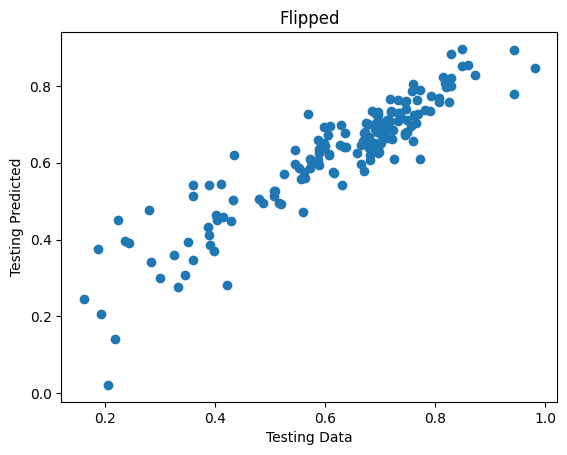

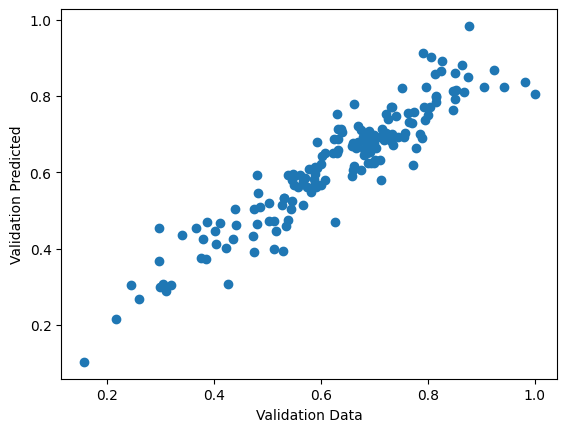

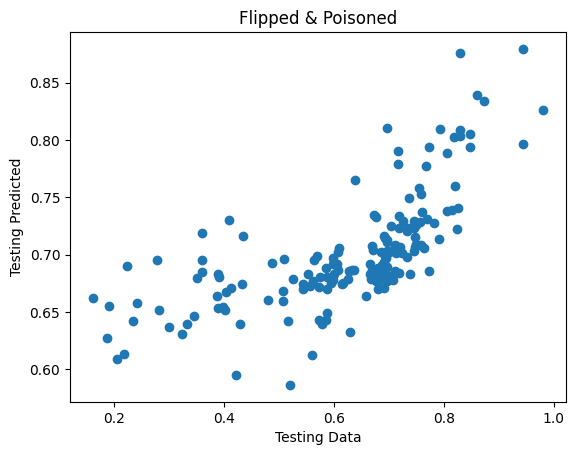

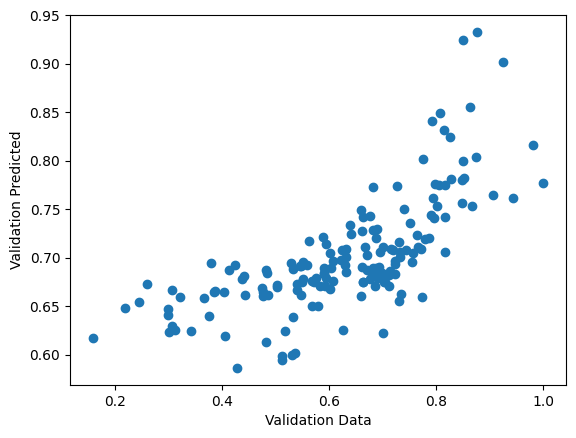


After Flipping, Unpoisoned 
 Validation MSE:  0.0035266882948545124 
 Test MSE: 0.00452093145874648

After Flipping & Poisoning:
 Validation MSE:  0.02173416446322987 
 Test MSE: 0.025715027363068674


In [5]:
# define parameters for poisoner
eta = 0.01 # gradient descent step size (note gradients are normalized)
beta = 0.05 # decay rate for line search
sigma = 0.9 # line search stop condition
epsilon = 1e-3 # poisoning stop condition
stop1 = 5
stop2 = 10
stop3 = 3
decrease_rate = 0.5

poiser = gd_poisoner.linear_poisoner(poi_train_x, poi_train_y, poi_test_x, poi_test_y, poi_val_x, poi_val_y, eta, beta, sigma, epsilon)
classifier, _ = poiser.learn_model(np.concatenate((poi_train_x, x_pois), axis=0), poi_train_y + y_pois, None)
print("classifier: ", classifier)
err = poiser.compute_error(classifier, False,False)[0]
x_pois = np.matrix(x_pois)
y_pois = y_pois[:]
for i in  range(5):
    # calculate the amt of data that should be poisoned in this iteration
    current_prop = (i + 1)*total_prop/5
    sample_amt = int(0.5 + train_ct*(current_prop/(1 - current_prop)))
    current_x_pois = x_pois[:sample_amt,:]
    current_y_pois = y_pois[:sample_amt]
    # poison data
    x_pois_result, y_pois_result = poiser.poison_data(current_x_pois, current_y_pois,stop1, stop2, stop3, decrease_rate)
    print(x_pois_result.shape,poi_train_x.shape)
    x_poised = np.concatenate((poi_train_x,x_pois_result),axis = 0)
    y_poised = poi_train_y + y_pois_result
    # train the model on poisoned data
    classifier_poised, _ = poiser.learn_model(x_poised,y_poised,None)
    classifier = poiser.init_classifier
    print("x_pois_result len: ",len(x_pois_result),", y_pois_result len: ",len(y_pois_result),", x_poised len: ",len(x_poised),", y_poised len: ",len(y_poised))
    print("classifier_poised ",classifier_poised,", classifier2 ",classifier)
    print(" ")
    if i != 4:
        err_unpoised = poiser.compute_error(classifier,False,False)
        err = poiser.compute_error(classifier_poised,False,False)
    else:
        err_unpoised = poiser.compute_error(classifier,True,False)
        err = poiser.compute_error(classifier_poised,True,True)

print("\nAfter Flipping, Unpoisoned \n Validation MSE: ", err_unpoised[0], "\n Test MSE:", err_unpoised[1])
print("\nAfter Flipping & Poisoning:\n Validation MSE: ", err[0], "\n Test MSE:", err[1])

# Perform B Flip and Linear Reg Poisoning

classifier:  LinearRegression()
*****************************
**** Poison Count:  51  ****
*****************************
Iteration  0 
Objective Value:  0.005369739504270623  Change:  0.005369739504270623
Validation MSE  0.004403471953046024 
Test MSE  0.005440114710552012
 
Iteration  1
Objective Value: 0.0068209659360027415  Difference:  0.0014512264317321187
 
Iteration  2
Objective Value: 0.0068209659360027415  Difference:  0.0
NO PROGRESS MADE!
 
Iteration  3
Objective Value: 0.0068209659360027415  Difference:  0.0
NO PROGRESS MADE!
 
Iteration  4
Objective Value: 0.0068209659360027415  Difference:  0.0
NO PROGRESS MADE!
 
(51, 20) (1319, 20)
x_pois_result len:  51 , y_pois_result len:  51 , x_poised len:  1370 , y_poised len:  1370
classifier_poised  LinearRegression() , classifier2  LinearRegression()
 
*****************************
**** Poison Count:  106  ****
*****************************
Iteration  0 
Objective Value:  0.00703767004187679  Change:  0.00703767004187679
Valida

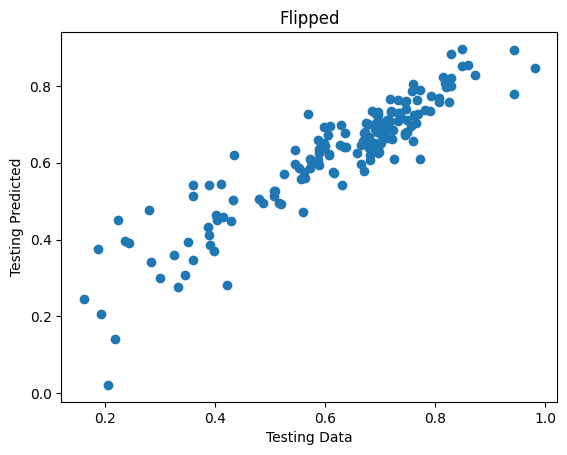

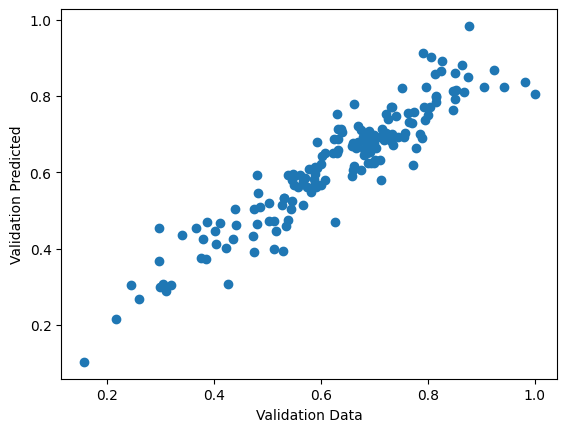

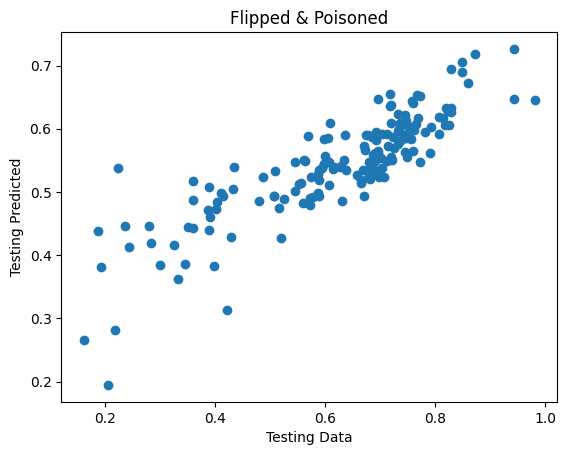

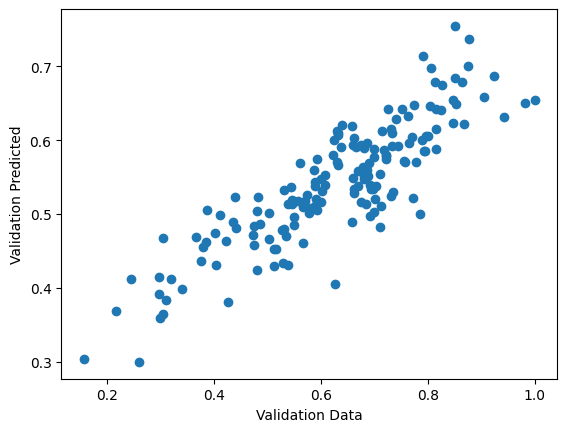


After Flipping, Unpoisoned 
 Validation MSE:  0.0035266882948545124 
 Test MSE: 0.00452093145874648

After Flipping & Poisoning:
 Validation MSE:  0.01762885949742776 
 Test MSE: 0.017936276563678893


In [6]:
x_pois, y_pois = flip_data.flip_data.B_flip(poi_train_x,poi_train_y,poison_ct)

poiser = gd_poisoner.linear_poisoner(poi_train_x, poi_train_y, poi_test_x, poi_test_y, poi_val_x, poi_val_y, eta, beta, sigma, epsilon)
classifier, _ = poiser.learn_model(np.concatenate((poi_train_x, x_pois), axis=0), poi_train_y + y_pois, None)
print("classifier: ", classifier)
err = poiser.compute_error(classifier, False,False)[0]
x_pois = np.matrix(x_pois)
y_pois = y_pois[:]
for i in  range(5):
    # calculate the amt of data that should be poisoned in this iteration
    current_prop = (i + 1)*total_prop/5
    sample_amt = int(0.5 + train_ct*(current_prop/(1 - current_prop)))
    current_x_pois = x_pois[:sample_amt,:]
    current_y_pois = y_pois[:sample_amt]
    # poison data
    x_pois_result, y_pois_result = poiser.poison_data(current_x_pois, current_y_pois,stop1, stop2, stop3, decrease_rate)
    print(x_pois_result.shape,poi_train_x.shape)
    x_poised = np.concatenate((poi_train_x,x_pois_result),axis = 0)
    y_poised = poi_train_y + y_pois_result
    # train the model on poisoned data
    classifier_poised, _ = poiser.learn_model(x_poised,y_poised,None)
    classifier = poiser.init_classifier
    print("x_pois_result len: ",len(x_pois_result),", y_pois_result len: ",len(y_pois_result),", x_poised len: ",len(x_poised),", y_poised len: ",len(y_poised))
    print("classifier_poised ",classifier_poised,", classifier2 ",classifier)
    print(" ")
    if i != 4:
        err_unpoised = poiser.compute_error(classifier,False,False)
        err = poiser.compute_error(classifier_poised,False,False)
    else:
        err_unpoised = poiser.compute_error(classifier,True,False)
        err = poiser.compute_error(classifier_poised,True,True)

print("\nAfter Flipping, Unpoisoned \n Validation MSE: ", err_unpoised[0], "\n Test MSE:", err_unpoised[1])
print("\nAfter Flipping & Poisoning:\n Validation MSE: ", err[0], "\n Test MSE:", err[1])